In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
from tqdm import tqdm
import dlib
#!pip install mediapipe
import mediapipe as mp
import seaborn as sns


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print(os.listdir("drive/MyDrive/datasci281"))

['test', 'train', 'project_eda.ipynb']


In [3]:
path = "drive/MyDrive/datasci281/"
train_dir = path + "test/"
test_dir = path + "train/"

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  happy  disgust  neutral  surprise   sad  fear
train    958   1774      111     1233       831  1247  1024
      angry  disgust  fear  happy  neutral   sad  surprise
test   3995      436  4097   7215     4965  4830      3171


Text(0.5, 1.0, 'Training Set Class Distribution')

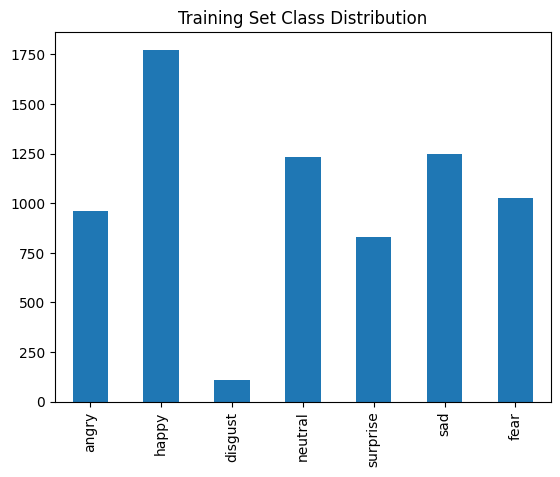

In [4]:
train_count.T.plot(kind='bar', legend=False)
plt.title('Training Set Class Distribution')

read a few images to see what they look like

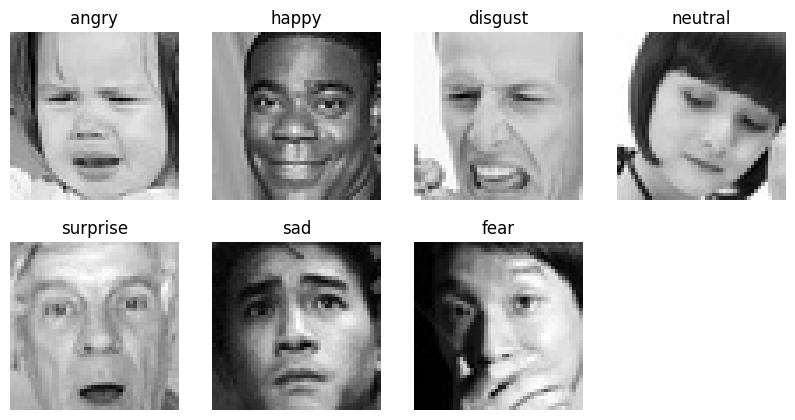

In [5]:
plt.figure(figsize=(10,5))

count = 0
for expression in os.listdir(train_dir):
    dir_ = train_dir + expression
    img_name = os.listdir(dir_)[0]
    img_path = dir_ + '/' + img_name
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 4, int(count)+1)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
    count += 1


plt.show()

## Basic Pixel Level EDA

In [6]:
df = pd.DataFrame(columns=['path', 'expression'])

for expression in os.listdir(train_dir):
    dir_ = train_dir + expression
    for img_name in os.listdir(dir_):
        img_path = dir_ + '/' + img_name
        df = pd.concat([df, pd.DataFrame({'path': [img_path], 'expression': [expression]})], ignore_index=True)
print(df.head())

                                                path expression
0  drive/MyDrive/datasci281/test/angry/PublicTest...      angry
1  drive/MyDrive/datasci281/test/angry/PublicTest...      angry
2  drive/MyDrive/datasci281/test/angry/PrivateTes...      angry
3  drive/MyDrive/datasci281/test/angry/PrivateTes...      angry
4  drive/MyDrive/datasci281/test/angry/PublicTest...      angry


In [7]:
print(f"Number of images: {len(df)}")

Number of images: 7178


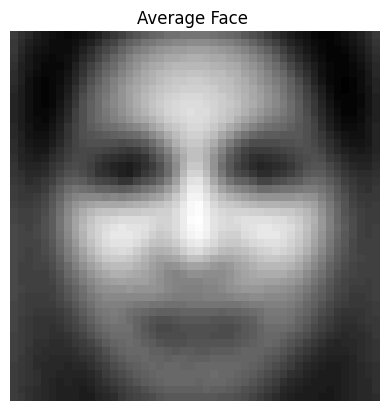

In [8]:
def compute_average_face(df, img_size=(48, 48)):
    total = np.zeros(img_size, dtype=np.float32)
    count = 0

    for path in df['path']:
        #if "angry" in path:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip broken/missing files
        img = cv2.resize(img, img_size)
        total += img.astype(np.float32)
        count += 1

    avg_face = (total / count).astype(np.uint8)
    return avg_face

avg_face = compute_average_face(df)
plt.imshow(avg_face, cmap='gray')
plt.title("Average Face ")
plt.axis('off')
plt.show()

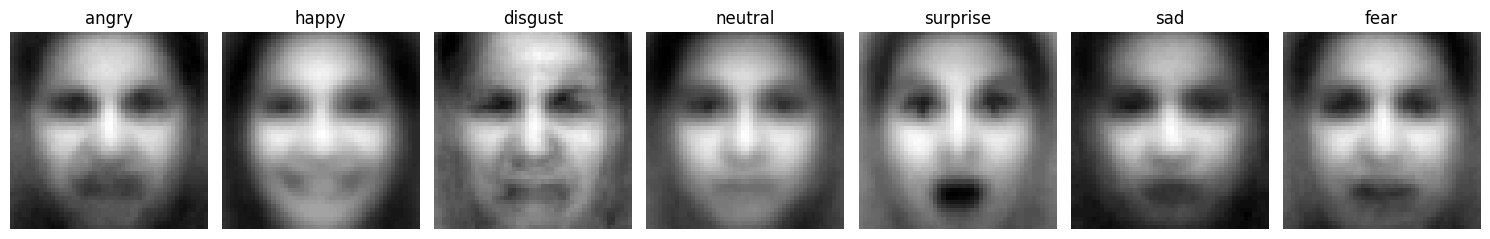

In [9]:
avg_faces = {}

for expr in df['expression'].unique():
    subset = df[df['expression'] == expr]
    avg_faces[expr] = compute_average_face(subset)

# Plot all mean faces
fig, axes = plt.subplots(1, len(avg_faces), figsize=(15, 5))
for ax, (expr, face) in zip(axes, avg_faces.items()):
    ax.imshow(face, cmap='gray')
    ax.set_title(expr)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Check on the mouth width or teeth

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def compute_average_face_color(df, img_size=(48, 48)):
    total = np.zeros((*img_size, 3), dtype=np.float32)
    count = 0

    for path in df['path']:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        total += img.astype(np.float32)
        count += 1

    avg_face = (total / count).astype(np.uint8)
    return avg_face

In [12]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  refine_landmarks=True,
                                  max_num_faces=1,
                                  min_detection_confidence=0.5)


MOUTH_LANDMARKS = list(range(0, 128))  # outer and inner lips

def get_mouth_landmarks(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)
    if not results.multi_face_landmarks:
        return None

    h, w, _ = image.shape
    landmarks = results.multi_face_landmarks[0]
    points = []
    for idx in MOUTH_LANDMARKS:
        lm = landmarks.landmark[idx]
        x, y = int(lm.x * w), int(lm.y * h)
        points.append((x, y))
    return np.array(points)

def crop_mouth(image, mouth_points, padding=0.25):
    x_min, y_min = np.min(mouth_points, axis=0)
    x_max, y_max = np.max(mouth_points, axis=0)

    w = x_max - x_min
    h = y_max - y_min

    pad_x = int(w * padding)
    pad_y = int(h * padding)

    x1 = max(0, x_min - pad_x)
    y1 = max(0, y_min - pad_y)
    x2 = min(image.shape[1], x_max + pad_x)
    y2 = min(image.shape[0], y_max + pad_y)

    return image[y1:y2, x1:x2], (x1, y1, x2, y2)

def get_mouth_edges(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    v = np.median(gray)
    lower = int(max(0, 0.66 * v))
    upper = int(min(255, 1.33 * v))

    edges = cv2.Canny(gray, lower, upper)
    return edges

def visualize_landmarks_and_edges(image, mouth_points, edges, bbox):
    vis = image.copy()
    x1, y1, x2, y2 = bbox

    # Draw landmarks
    for (x, y) in mouth_points:
        cv2.circle(vis, (x, y), 1, (0, 255, 0), -1)

    # Overlay edges
    edge_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    edge_color = cv2.resize(edge_color, (x2 - x1, y2 - y1))
    vis[y1:y2, x1:x2] = cv2.addWeighted(vis[y1:y2, x1:x2], 0.7, edge_color, 0.7, 0)

    return vis

  0%|          | 0/7178 [00:00<?, ?it/s]

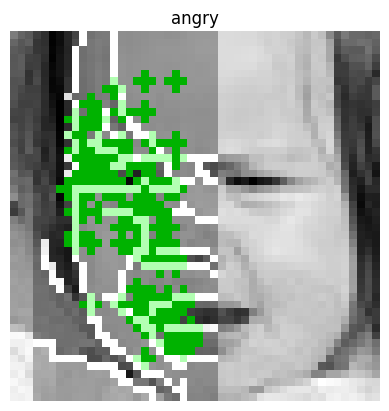

  0%|          | 1/7178 [00:00<12:36,  9.49it/s]

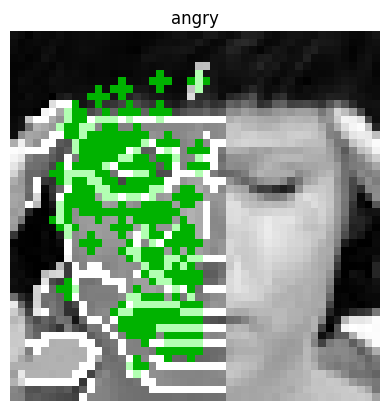

  0%|          | 2/7178 [00:00<12:39,  9.45it/s]

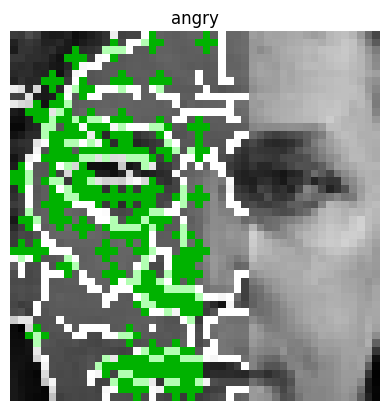

100%|██████████| 7178/7178 [02:26<00:00, 49.00it/s]


In [13]:
results = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row['path'])
    if img is None:
        continue

    mouth_points = get_mouth_landmarks(img)
    if mouth_points is None:
        continue

    roi, bbox = crop_mouth(img, mouth_points)
    edges = get_mouth_edges(roi)

    # Compute basic metrics
    edge_ratio = np.sum(edges > 0) / edges.size

    results.append({
        'path': row['path'],
        'expression': row['expression'],
        'edge_ratio': edge_ratio
    })

    # Optional visualization (for the first few)
    if i < 5:
        vis = visualize_landmarks_and_edges(img, mouth_points, edges, bbox)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"{row['expression']}")
        plt.axis('off')
        plt.show()

df_features = pd.DataFrame(results)

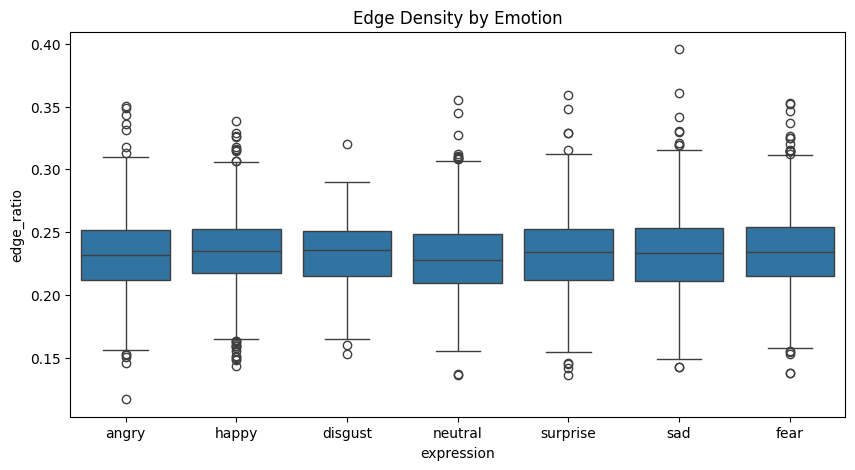

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x='expression', y='edge_ratio', data=df_features)
plt.title('Edge Density by Emotion')
plt.show()

In [26]:
summary = df_features.groupby('expression')['edge_ratio'].agg(['mean', 'median', 'max', "min"]).reset_index()
summary = summary.sort_values(by='mean', ascending=False)
summary

,expression,mean,median,max,min
2,fear,0.234935,0.234043,0.353066,0.137500
3,happy,0.234516,0.234722,0.338141,0.143229
6,surprise,0.233173,0.234217,0.358974,0.135913
5,sad,0.232703,0.233333,0.395604,0.142361
0,angry,0.232643,0.231944,0.350427,0.117021
1,disgust,0.231997,0.236111,0.320513,0.152778
4,neutral,0.229537,0.227778,0.355357,0.136272


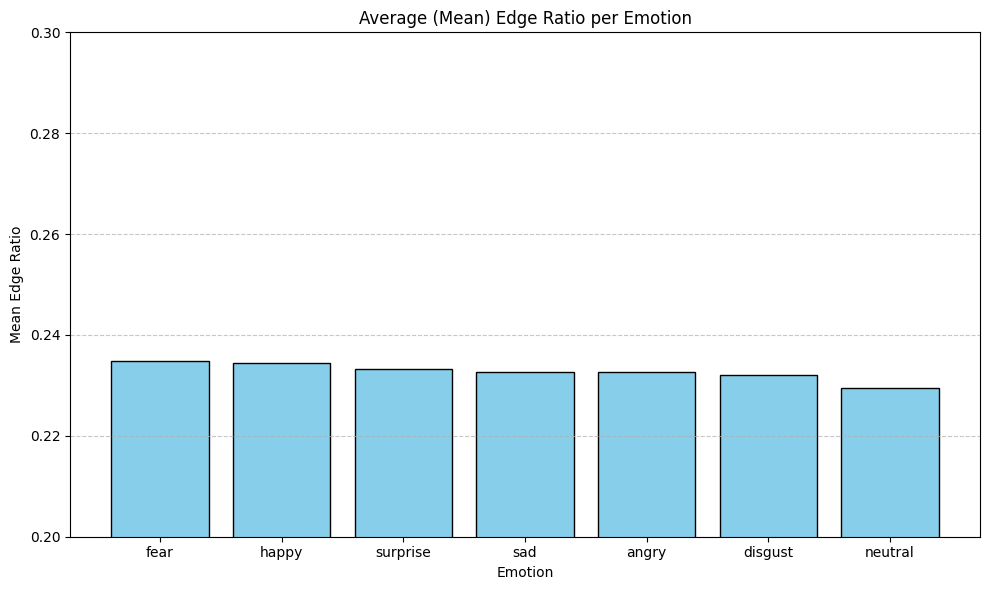

In [27]:
plt.figure(figsize=(10, 6))
plt.ylim(0.2, 0.3)
plt.bar(summary['expression'], summary['mean'], color='skyblue', edgecolor='black')

plt.title('Average (Mean) Edge Ratio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Mean Edge Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

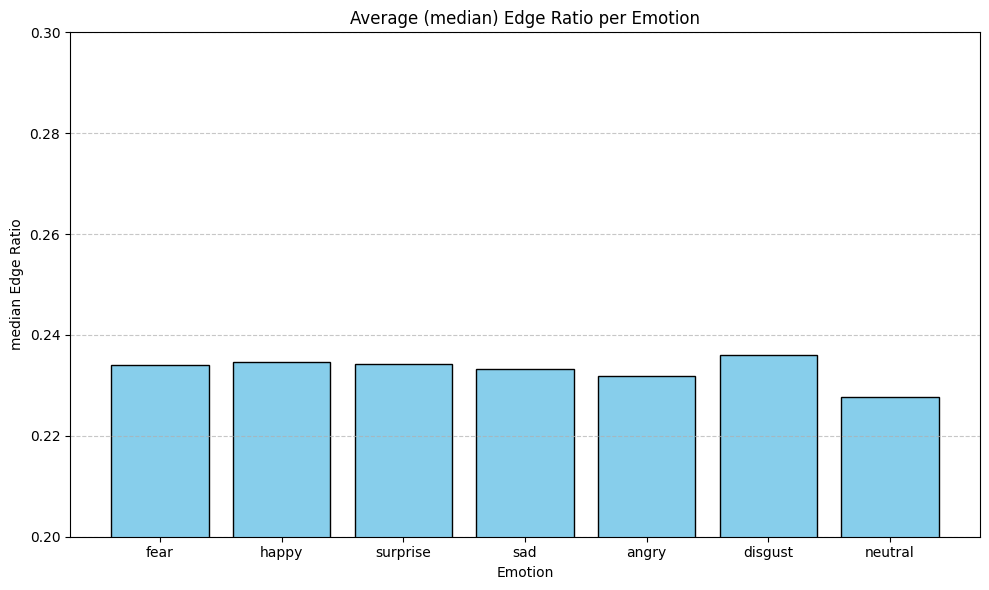

In [28]:
plt.figure(figsize=(10, 6))
plt.ylim(0.2, 0.3)
plt.bar(summary['expression'], summary['median'], color='skyblue', edgecolor='black')

plt.title('Average (median) Edge Ratio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('median Edge Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

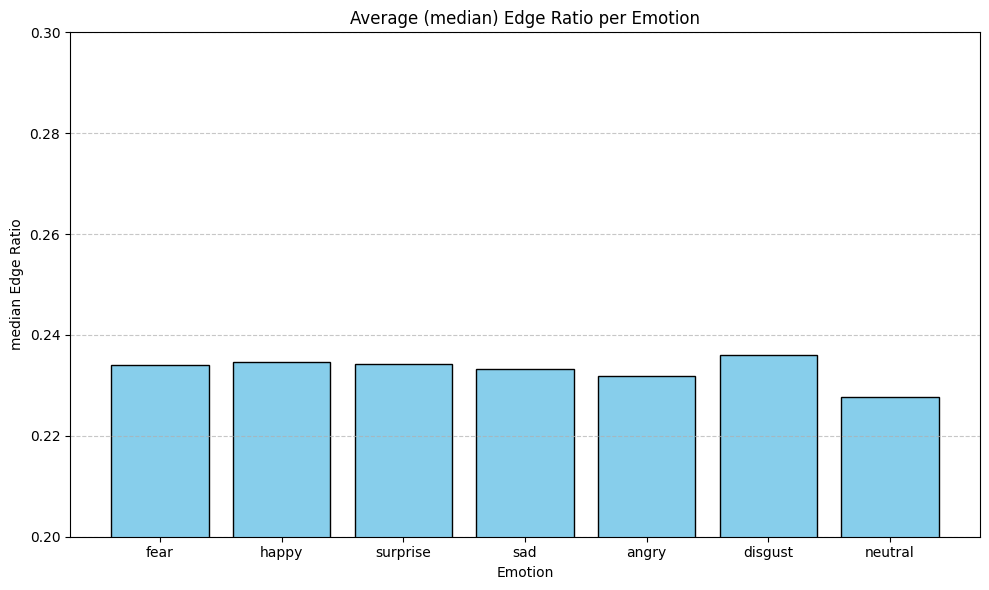

In [29]:
plt.figure(figsize=(10, 6))
plt.ylim(0.2, 0.3)
plt.bar(summary['expression'], summary['median'], color='skyblue', edgecolor='black')

plt.title('Average (median) Edge Ratio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('median Edge Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

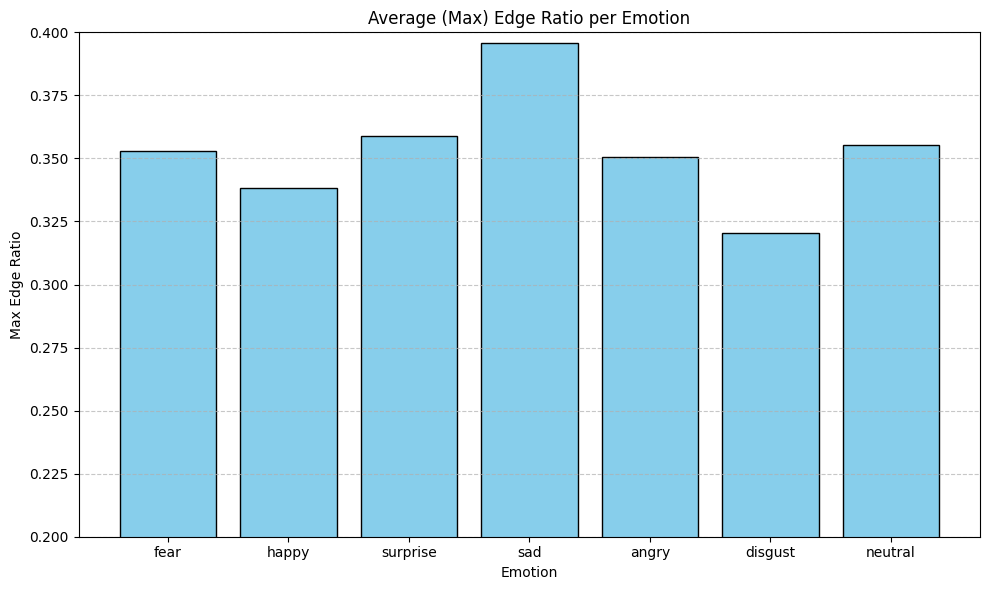

In [31]:
plt.figure(figsize=(10, 6))
plt.ylim(0.2, 0.4)
plt.bar(summary['expression'], summary['max'], color='skyblue', edgecolor='black')

plt.title('Average (Max) Edge Ratio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Max Edge Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

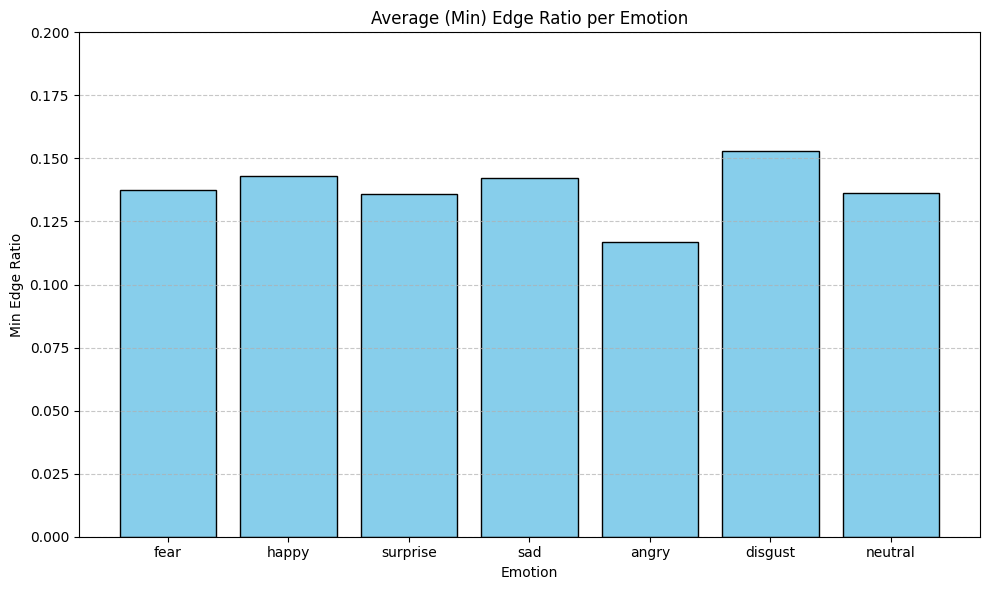

In [33]:
plt.figure(figsize=(10, 6))
plt.ylim(0.0, 0.2)
plt.bar(summary['expression'], summary['min'], color='skyblue', edgecolor='black')

plt.title('Average (Min) Edge Ratio per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Min Edge Ratio')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()